In [595]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import functools

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

plt.style.use('ggplot')
%matplotlib inline

In [2]:
holyc_df = pd.read_csv('../tmp/clean/holyokecon_confessional_comments.csv')
holyr_df = pd.read_csv('../tmp/clean/holyokecon_confessional_reports.csv')
holys_df = pd.read_csv('../tmp/clean/holyokecon_confessional_secrets.csv')
smithc_df = pd.read_csv('../tmp/clean/holyokecon_confessional_comments.csv')
smithr_df = pd.read_csv('../tmp/clean/holyokecon_confessional_reports.csv')
smiths_df = pd.read_csv('../tmp/clean/holyokecon_confessional_secrets.csv')

In [99]:
def word_counter(text, n=0, length_thres=50):
    t = text.split()
    t = [tk for tk in t if len(tk) < length_thres]
    if n > 0:
        for i in range(n):
            t_ngrams = [" ".join(b) for b in list(ngrams(t, i + 1))]
            t.extend(t_ngrams)
    return Counter(t)

def word_aggregater(corpus_list, n=0):
    c = Counter()
    for doc in corpus_list:
        c.update(word_counter(doc, n=n))
    return c

In [260]:
smithc_df.head()

,id,clean_tokens,secret_id
0,5,fuck yes,14042
1,4,amen,14042
2,3,dont sleep,14040
3,6,sleep weak,14040
4,7,yes,12515


In [100]:
corpus = smithc_df['clean_tokens'][smithc_df['clean_tokens'].notnull()]
token_counts = word_aggregater(corpus, n=3).items()
token_df = pd.DataFrame(token_counts)
token_df.columns = ['word', 'frequency']

# filter
token_df = token_df[token_df['frequency'] > 5]

# sort
token_df = token_df.sort_values('frequency', ascending=True)

# compute grams
token_df['ngrams'] = token_df['word'].apply(lambda x: len(x.split()))

# reset index
token_df.reset_index(inplace=True, drop=True)
token_df.head()

,word,frequency,ngrams
15052161,crazy gender,6,2
3399670,block help,6,2
8553718,aquiline aquiver,6,2
3399700,one ever find,6,3
3399714,speak proper,6,2


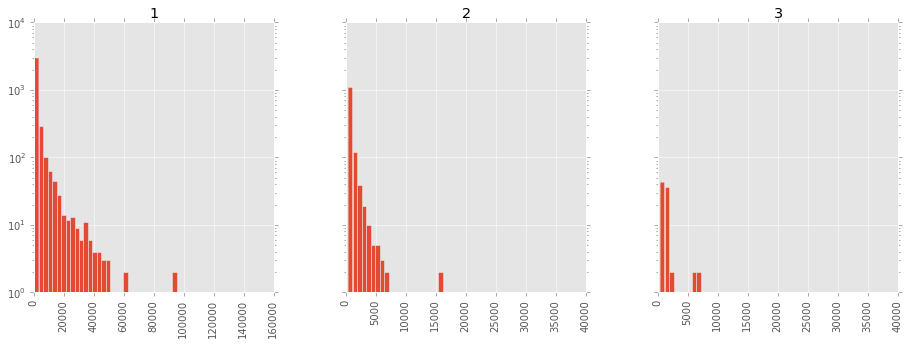

In [682]:
plot_options = {
    'column': 'frequency',
    'by': 'ngrams',
    'figsize': (15,5),
    'bins': 50,
    'log': True,
    'layout': (1,3),
    'sharey': True
#     'orientation': 'horizontal
}

uni_bi_tri_gram = token_df[token_df['ngrams'] <= 3]
ubt_gram_tail = uni_bi_tri_gram.tail(5000)
ugram_tail = ubt_gram_tail[ubt_gram_tail['ngrams'] == 1]
bgram_tail = ubt_gram_tail[ubt_gram_tail['ngrams'] == 2]
tgram_tail = ubt_gram_tail[ubt_gram_tail['ngrams'] == 3]
ubt_gram_tail.hist(**plot_options);

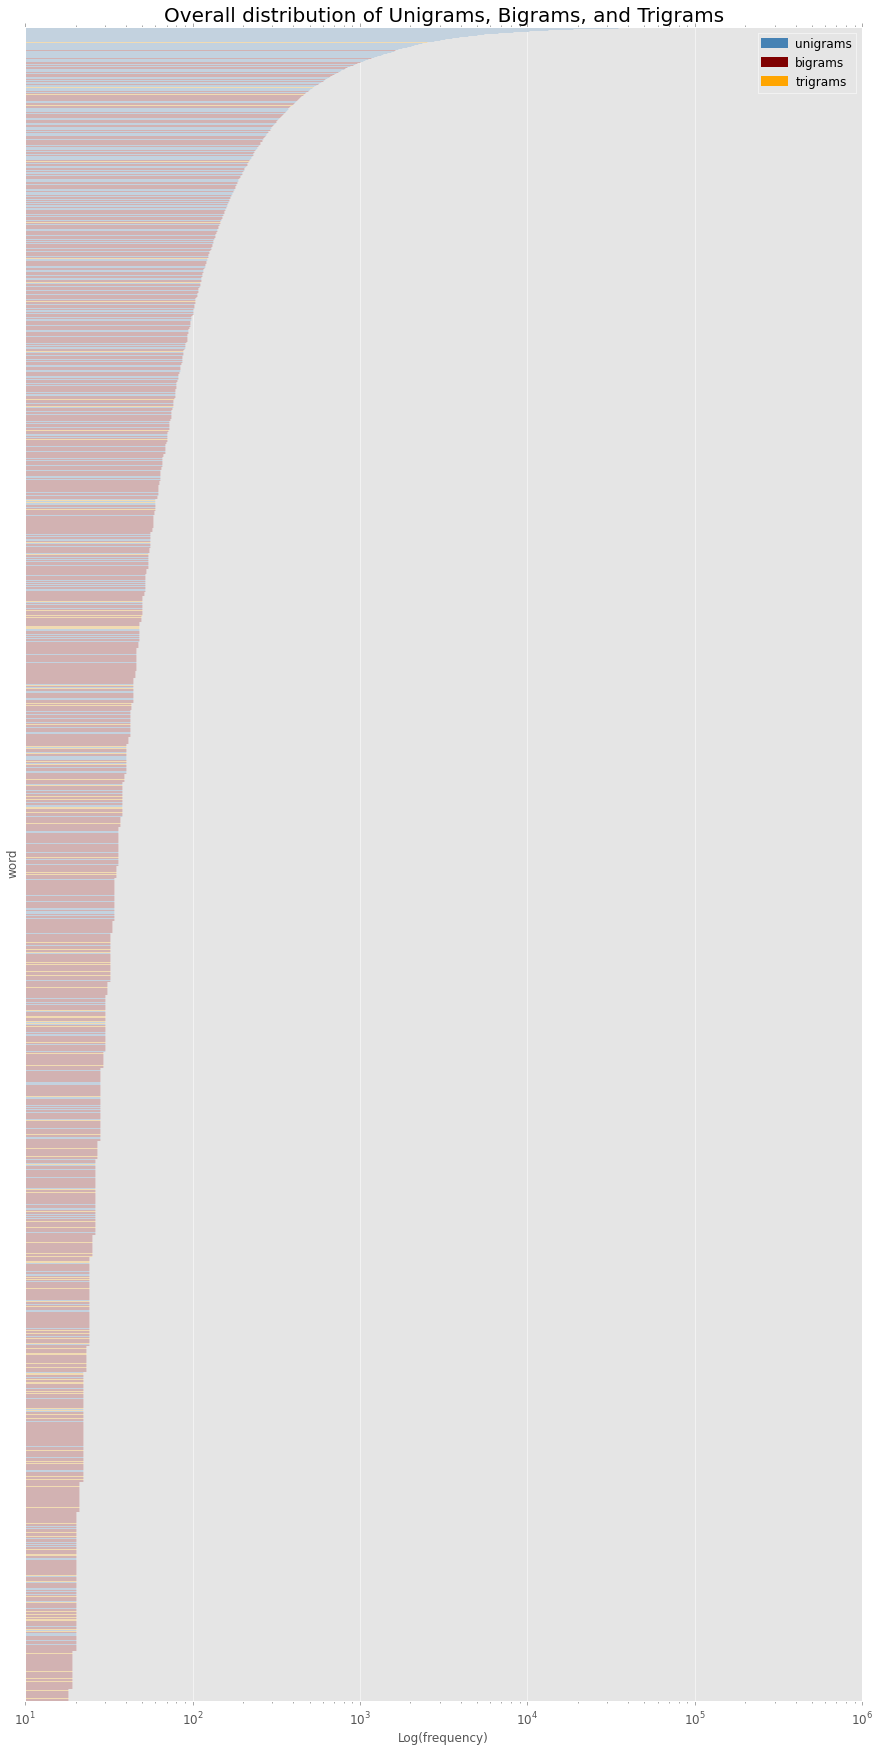

In [566]:
plot_options = {
    'x': 'word',
    'y': 'frequency',
    'kind': 'barh',
    'figsize': (15,30),
    'stacked': True,
    'width': 1,
    'fontsize': 12,
    'yticks': [],
    'logx': True,
    'legend': False,
}

ubt_gram_tail = uni_bi_tri_gram.tail(100000)

colors = {1: 'steelblue', 2: 'maroon', 3: 'orange'}
ax = ubt_gram_tail.plot(color=[colors[i] for i in ubt_gram_tail['ngrams']], **plot_options);

ax.set_xlabel("Log(frequency)")
ax.set_title('Overall distribution of Unigrams, Bigrams, and Trigrams', fontsize=20)
uni_artist = plt.Line2D((0,1),(0,0), color=colors[1], linestyle='-', linewidth=10.0)
bi_artist = plt.Line2D((0,1),(0,0), color=colors[2], linestyle='-', linewidth=10.0)
tri_artist = plt.Line2D((0,1),(0,0), color=colors[3], linestyle='-', linewidth=10.0)

#Create legend from custom artist/label lists
ax.legend([uni_artist, bi_artist, tri_artist],
          ['unigrams', 'bigrams', 'trigrams']);

In [161]:
unigrams = token_df[token_df['ngrams'] == 1]
bigrams = token_df[token_df['ngrams'] == 2]
trigrams = token_df[token_df['ngrams'] == 3]

In [266]:
unigrams.tail()

,word,frequency,ngrams
528154,think,93120,1
528155,get,104294,1
528156,people,129876,1
528157,like,145638,1
528158,dont,148672,1


In [267]:
bigrams.tail()

,word,frequency,ngrams
527996,dont think,13298,2
528024,dont know,15575,2
528031,nigger nigger,16006,2
528061,fap fap,19197,2
528129,rmoney rmoney,37999,2


In [268]:
trigrams.tail()

,word,frequency,ngrams
527834,post post post,6964,3
527916,fuck fuck fuck,9488,3
528029,nigger nigger nigger,15924,3
528060,fap fap fap,19142,3
528128,rmoney rmoney rmoney,37994,3


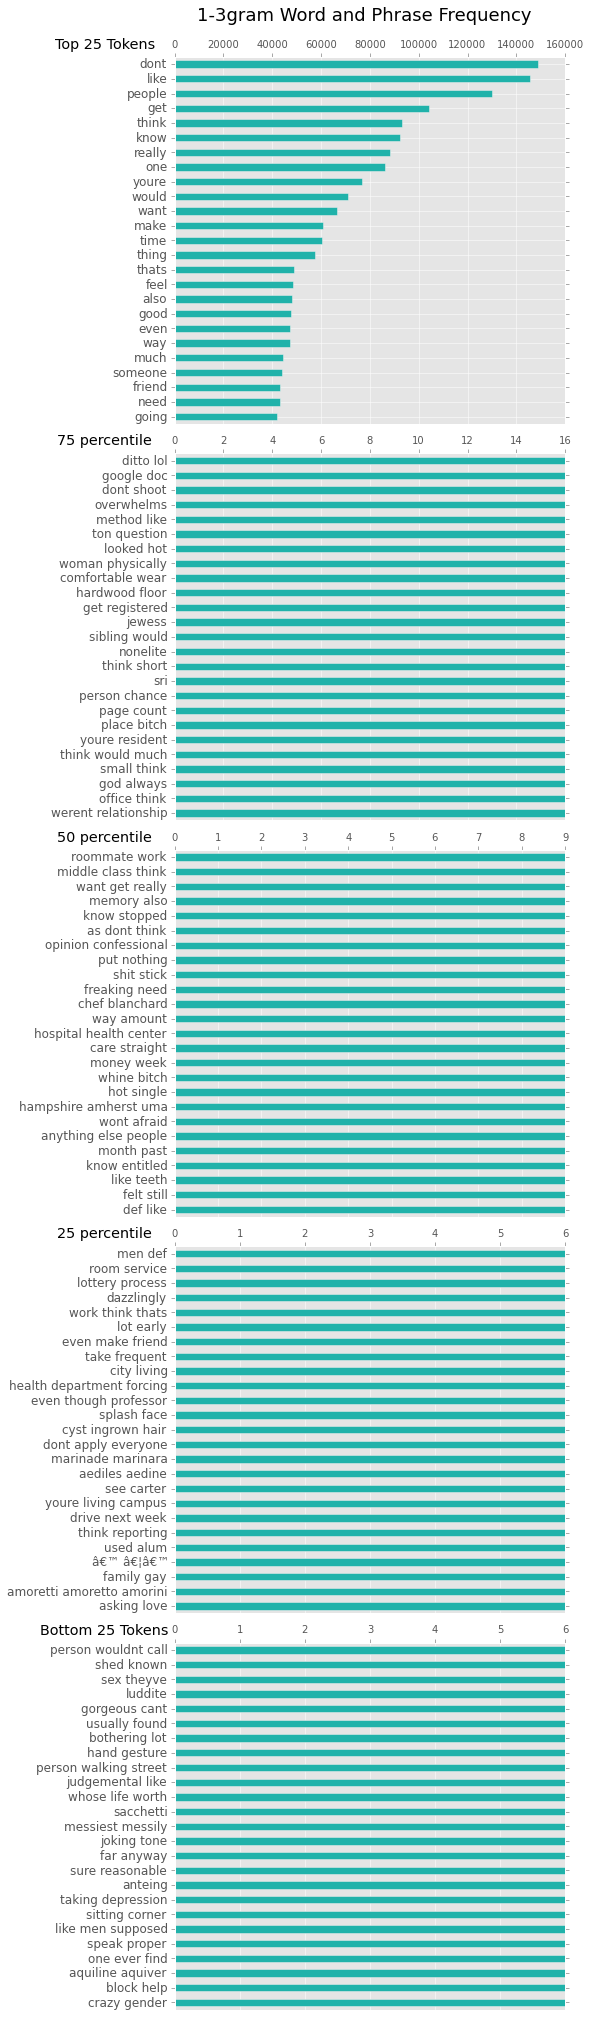

In [511]:
plot_options = {
    'x': 'word',
    'y': 'frequency',
    'kind': 'barh',
    'subplots': True, 
    'stacked': True,
    'legend': False,
    'fontsize': 12,
}

def plot_ngrams(df, plot_options, **kwargs):
    plot_options.update(kwargs)
    plot = df.plot(**plot_options)[0]
    plot.set_xlabel("frequency")
    plot.set_ylabel("")
    
def percentile_plot_ngrams(ngram_df, fixed_plot_options, main_title, **var_plot_options):
    ptile_25 = int(ngram_df.shape[0] / 4)
    ptile_50 = ptile_25 * 2
    ptile_75 = ptile_25 * 3

    n = 25
    ngrams_ptile_top = ngram_df.tail(n)
    ngrams_ptile_75 = ngram_df.iloc[ptile_75: ptile_75 + n]
    ngrams_ptile_50 = ngram_df.iloc[ptile_50: ptile_50 + n]
    ngrams_ptile_25 = ngram_df.iloc[ptile_25: ptile_25 + n]
    ngrams_ptile_bottom = ngram_df.head(n)

    fig, axes = plt.subplots(5, 1, figsize=(7, 35))
    plt.subplots_adjust(hspace=0.08)
    plt.suptitle(main_title, y=0.92, fontsize=18)

    fixed_plot_options.update(var_plot_options)
    
    plot_ngrams(ngrams_ptile_top, fixed_plot_options, subplots=True, ax=axes[0])
    plot_ngrams(ngrams_ptile_75, fixed_plot_options, subplots=True, ax=axes[1])
    plot_ngrams(ngrams_ptile_50, fixed_plot_options, subplots=True, ax=axes[2])
    plot_ngrams(ngrams_ptile_25, fixed_plot_options, subplots=True, ax=axes[3])
    plot_ngrams(ngrams_ptile_bottom, fixed_plot_options, subplots=True, ax=axes[4])
    
    def format_axes(ax, title):
        title_options = {
            'x': -0.18,
            'y': 1.01
        }
        ax.set_title(title, **title_options)
        ax.xaxis.tick_top()
        ax.set_xlabel("")
        return ax
    
    format_axes(axes[0], "Top %s Tokens" % n)
    format_axes(axes[1], "75 percentile")
    format_axes(axes[2], "50 percentile")
    format_axes(axes[3], "25 percentile")
    format_axes(axes[4], "Bottom %s Tokens" % n)

uni_bi_tri_gram = token_df[token_df['ngrams'] <= 3]
percentile_plot_ngrams(uni_bi_tri_gram, plot_options, 
                       "1-3gram Word and Phrase Frequency",
                       color='lightseagreen')

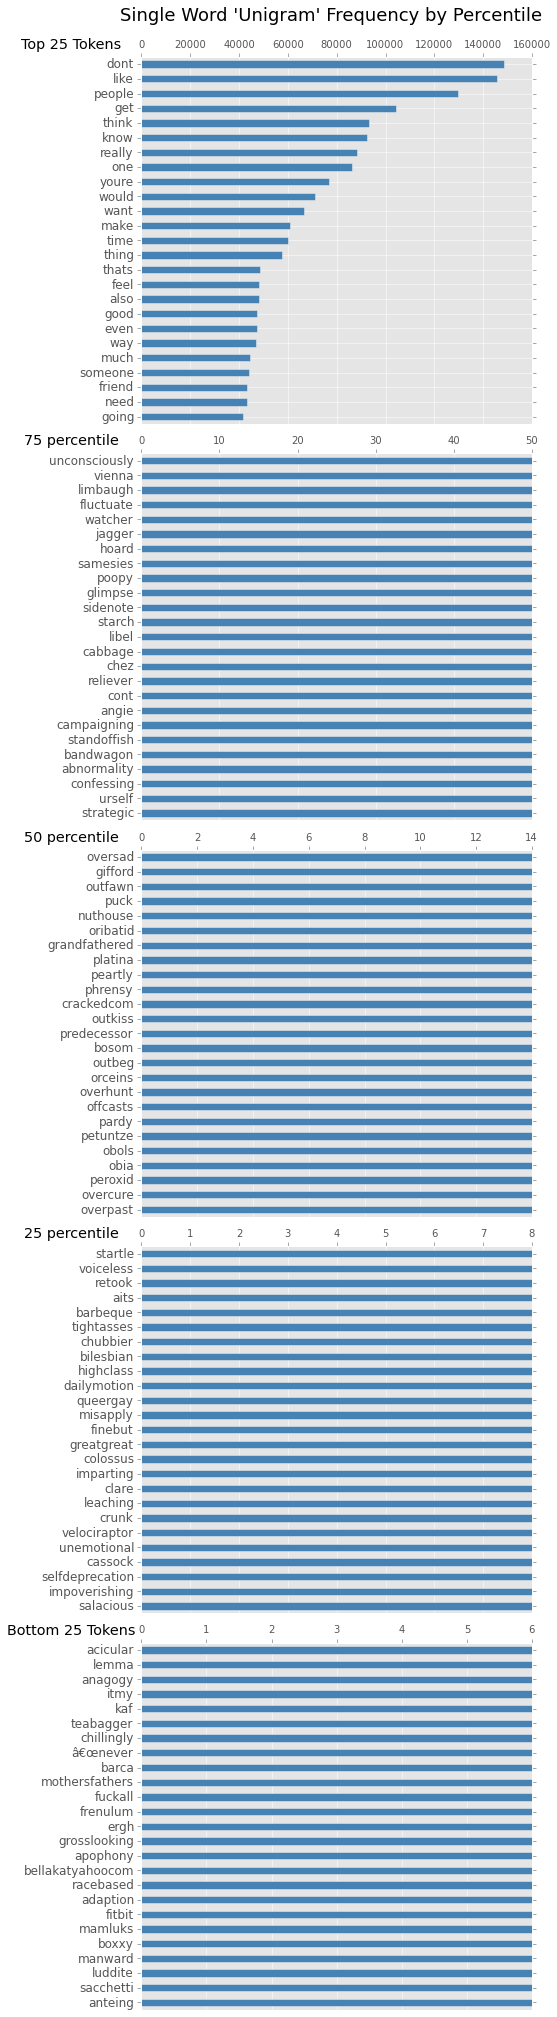

In [509]:
percentile_plot_ngrams(unigrams, plot_options, 
                       "Single Word 'Unigram' Frequency by Percentile", 
                       color='steelblue')

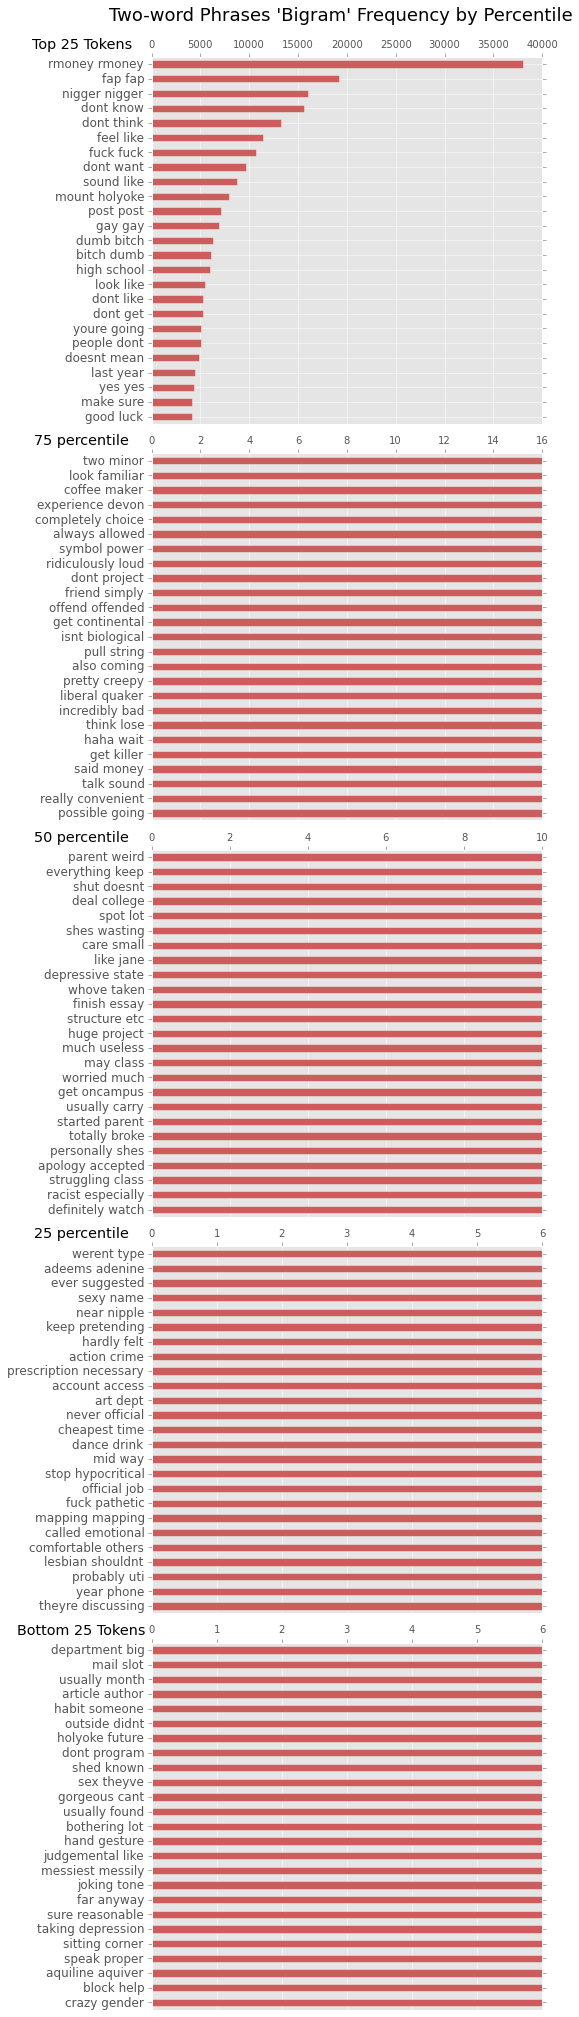

In [493]:
percentile_plot_ngrams(bigrams, plot_options, 
                       "Two-word Phrases 'Bigram' Frequency by Percentile",
                       color='indianred')

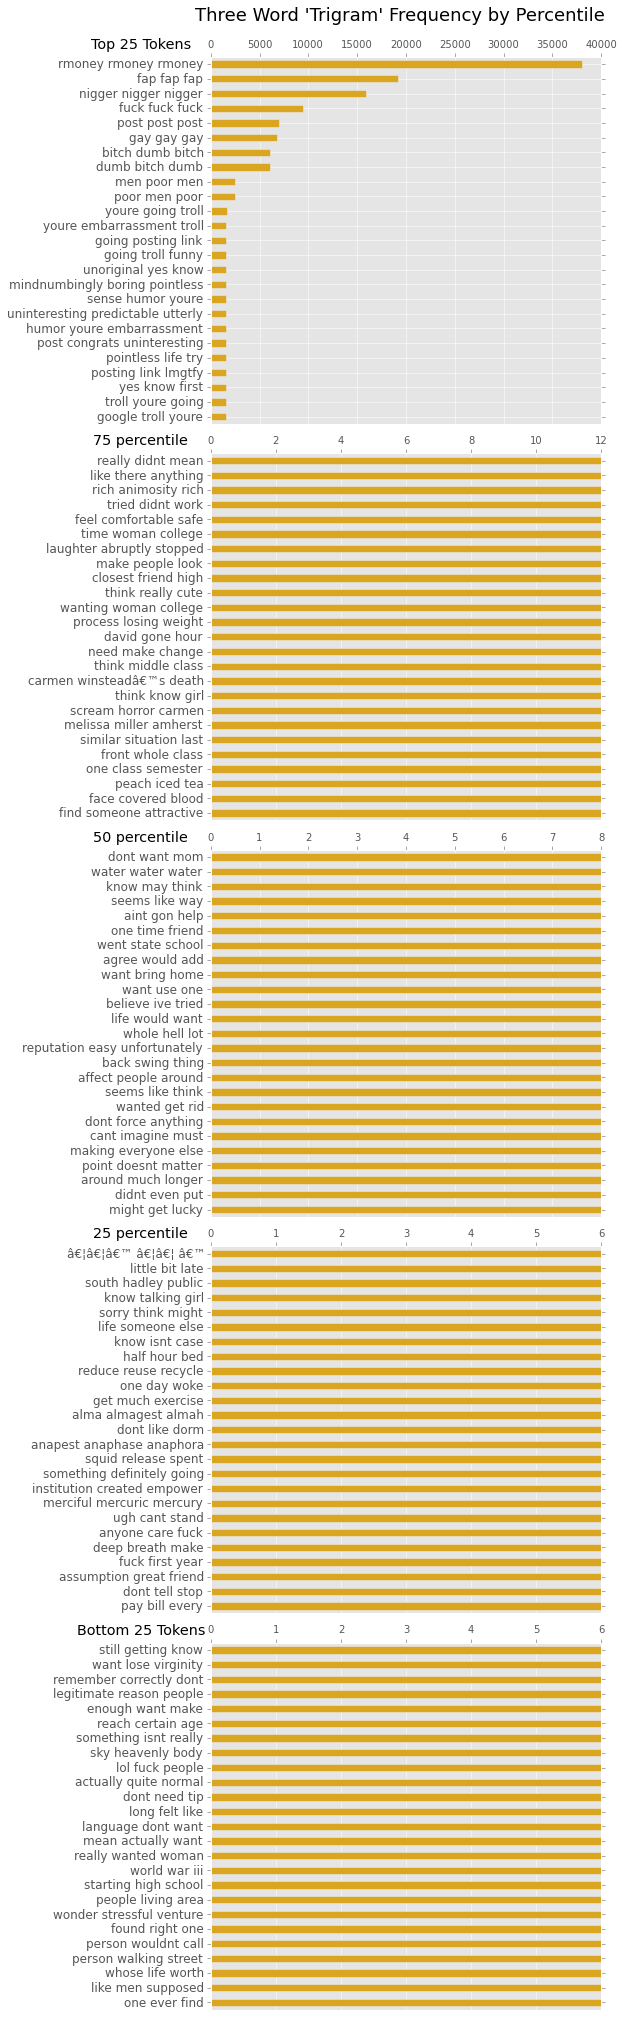

In [494]:
percentile_plot_ngrams(trigrams, plot_options, 
                       "Three Word 'Trigram' Frequency by Percentile",
                       color='goldenrod')